In [1]:
import matplotlib.pyplot as plt
import pandas as pd, numpy as np

In [2]:
from vivarium import Artifact
art = Artifact('/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/alabama.hdf', filter_terms=['year_start == 2019', 'age_start >=  25'])

In [3]:
def load_artifact_data(word:str, cause:str, measure:str):
    master_art_data = pd.DataFrame()
    for i in ['alabama']: 

        art = Artifact('/mnt/share/costeffectiveness/artifacts/vivarium_nih_us_cvd/' + i + '.hdf', 
                   filter_terms=['year_start == 2019', 'age_start >=  25']) # << MIGHT WANT TO CHANGE THESE TERMS
        
        data = art.load(word + '.' + cause + '.' + measure)
        
        data = data.apply(pd.DataFrame.describe, axis=1).filter(['mean']).reset_index()
        
        data['location'] = i.capitalize()
        data['measure'] = measure
        data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
        master_art_data = master_art_data.append(data)
        
    return master_art_data

## Assumptions (can edit here and rerun)

In [18]:
sbp_per_med = 0.125
ldl_per_med = 0.125
percent_both_med = 0.125
sbp_percent_outreach = 0.08
ldl_percent_outreach = 0.125

#Percent outreach is the amount of folks reached by the outreach intervention.
#Currently it is 1/2 of the primary non-adherent folks 
#SBP percent outreach is used for the both medications category 
#Currently, 37.5% of total simualtns are medicated on one or both types of medication 

In [19]:
newly_medicated_sbp = sbp_per_med * sbp_percent_outreach
newly_medicated_ldl = ldl_per_med * ldl_percent_outreach
newly_medicated_both = percent_both_med * sbp_percent_outreach
other = 1 - (newly_medicated_sbp + newly_medicated_ldl + newly_medicated_both)
print(newly_medicated_sbp, newly_medicated_ldl, newly_medicated_both, other)

0.01 0.015625 0.01 0.964375


#### Known assumptions and limitations: 
1. I assume that once medicated your exposure decreases to the TMREL. This is not always the case (non-responders, minimal benefit folks) and would lead to an overestimation of the effect 
2. Assumes that medication is randomly distributed across age/sex/starting SBP level. This is not true, the most in need would be more likely to receive medication which would lead to an underestimation of effect 
3. I don't have good data on the percent of folks that are medicated today 

## Impact on MI for SBP and LDL-C

In [20]:
sbp_paf = load_artifact_data('risk_factor', 'high_systolic_blood_pressure', 'population_attributable_fraction')
sbp_MI_paf = sbp_paf.loc[sbp_paf['affected_entity'] == 'acute_myocardial_infarction']
sbp_MI_paf = sbp_MI_paf.rename(columns={"mean": "paf_MI_sbp"}).reset_index()
#sbp_MI_paf.head()

/tmp/ipykernel_569191/1403476964.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_art_data = master_art_data.append(data)


In [21]:
ldl_paf = load_artifact_data('risk_factor', 'high_ldl_cholesterol', 'population_attributable_fraction')
ldl_MI_paf = ldl_paf.loc[ldl_paf['affected_entity'] == 'acute_myocardial_infarction']
ldl_MI_paf = ldl_MI_paf.rename(columns={"mean": "paf_MI_ldl"}).reset_index()
#ldl_MI_paf.head()

/tmp/ipykernel_569191/1403476964.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_art_data = master_art_data.append(data)


In [22]:
MI_inc = load_artifact_data('cause', 'myocardial_infarction', 'incidence_rate')
MI_inc = MI_inc.rename(columns={"mean": "MI_inc"}).reset_index()
#MI_inc.head()

/tmp/ipykernel_569191/1403476964.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_art_data = master_art_data.append(data)


In [23]:
MI = (MI_inc.merge(sbp_MI_paf[['age_start','sex','paf_MI_sbp']], on=['age_start','sex'])
            .merge(ldl_MI_paf[['age_start','sex','paf_MI_ldl']], on=['age_start','sex']))
MI['paf_MI_both'] = 1 - ((1-MI['paf_MI_sbp']) * (1-MI['paf_MI_ldl']))

MI['inc_no_sbp'] = MI['MI_inc'] * (1-MI['paf_MI_sbp'])
MI['inc_no_ldl'] = MI['MI_inc'] * (1-MI['paf_MI_ldl'])
MI['inc_no_sbp_ldl'] = MI['MI_inc'] * (1-MI['paf_MI_both'])

MI['new_inc'] = (newly_medicated_sbp*MI['inc_no_sbp']) + (newly_medicated_ldl*MI['inc_no_ldl']) + (newly_medicated_both*MI['inc_no_sbp_ldl']) + (other * MI['MI_inc'])
MI.head()

,index,sex,age_start,age_end,year_start,year_end,MI_inc,location,measure,paf_MI_sbp,paf_MI_ldl,paf_MI_both,inc_no_sbp,inc_no_ldl,inc_no_sbp_ldl,new_inc
0,0,female,25.0,30.0,2019,2020,0.000452,Alabama,incidence_rate,0.320239,0.748039,0.828727,0.000307,0.000114,0.000077,0.000441
1,1,female,30.0,35.0,2019,2020,0.000510,Alabama,incidence_rate,0.273694,0.752440,0.820196,0.000370,0.000126,0.000092,0.000498
2,2,female,35.0,40.0,2019,2020,0.000426,Alabama,incidence_rate,0.313326,0.771580,0.843150,0.000293,0.000097,0.000067,0.000416
3,3,female,40.0,45.0,2019,2020,0.000540,Alabama,incidence_rate,0.356119,0.754799,0.842120,0.000347,0.000132,0.000085,0.000527
4,4,female,45.0,50.0,2019,2020,0.000850,Alabama,incidence_rate,0.472322,0.735079,0.860207,0.000448,0.000225,0.000119,0.000829


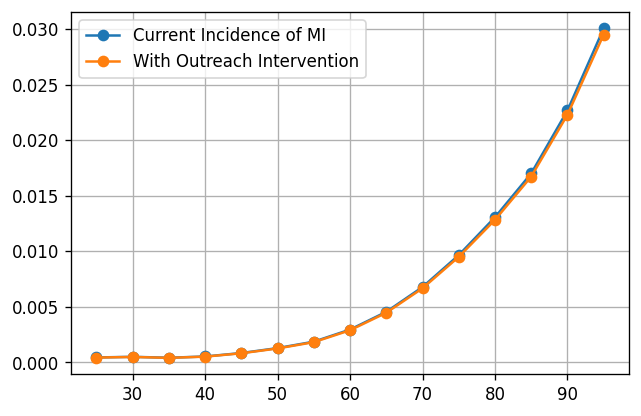

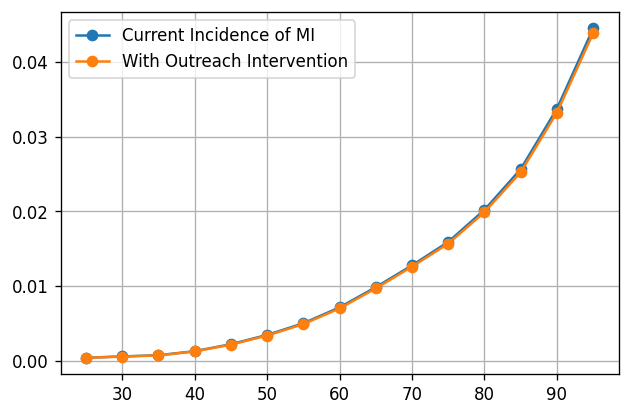

In [24]:
for sex in MI.sex.unique():
    plt.figure(dpi=120)
    subdata = MI.loc[MI['sex']==sex]
    plt.plot(subdata.age_start, subdata.MI_inc, marker='o', label='Current Incidence of MI')
    plt.plot(subdata.age_start, subdata.new_inc, marker='o', label='With Outreach Intervention')
    plt.legend()
    plt.grid()

### In concrete values for 1 year in the US = 213,000,000 person years
Is only those 25+ 

In [25]:
MI['decrease_MI'] = (MI['MI_inc'] - MI['new_inc']) * 213000000
MI['decrease_MI'].sum()

1047254.0147112255

## Impact on Stroke for SBP and LDL-C

In [26]:
sbp_stroke_paf = sbp_paf.loc[sbp_paf['affected_entity'] == 'acute_ischemic_stroke']
sbp_stroke_paf = sbp_stroke_paf.rename(columns={"mean": "paf_stroke_sbp"}).reset_index()
#sbp_stroke_paf.head()

In [27]:
ldl_stroke_paf = ldl_paf.loc[ldl_paf['affected_entity'] == 'acute_ischemic_stroke']
ldl_stroke_paf = ldl_stroke_paf.rename(columns={"mean": "paf_stroke_ldl"}).reset_index()
#ldl_stroke_paf.head()

In [28]:
stroke_inc = load_artifact_data('cause', 'ischemic_stroke', 'incidence_rate')
stroke_inc = stroke_inc.rename(columns={"mean": "stroke_inc"}).reset_index()
#stroke_inc.head()

/tmp/ipykernel_569191/1403476964.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  master_art_data = master_art_data.append(data)


In [29]:
stroke = (stroke_inc.merge(sbp_stroke_paf[['age_start','sex','paf_stroke_sbp']], on=['age_start','sex'])
            .merge(ldl_stroke_paf[['age_start','sex','paf_stroke_ldl']], on=['age_start','sex']))
stroke['paf_stroke_both'] = 1 - ((1-stroke['paf_stroke_sbp']) * (1-stroke['paf_stroke_ldl']))

stroke['inc_no_sbp'] = stroke['stroke_inc'] * (1-stroke['paf_stroke_sbp'])
stroke['inc_no_ldl'] = stroke['stroke_inc'] * (1-stroke['paf_stroke_ldl'])
stroke['inc_no_sbp_ldl'] = stroke['stroke_inc'] * (1-stroke['paf_stroke_both'])

stroke['new_inc'] = (newly_medicated_sbp*stroke['inc_no_sbp']) + (newly_medicated_ldl*stroke['inc_no_ldl']) + (newly_medicated_both*stroke['inc_no_sbp_ldl']) + (other * stroke['stroke_inc'])
stroke.head()

,index,sex,age_start,age_end,year_start,year_end,stroke_inc,location,measure,paf_stroke_sbp,paf_stroke_ldl,paf_stroke_both,inc_no_sbp,inc_no_ldl,inc_no_sbp_ldl,new_inc
0,0,female,25.0,30.0,2019,2020,0.000116,Alabama,incidence_rate,0.296663,0.611811,0.726972,0.000081,0.000045,0.000032,0.000113
1,1,female,30.0,35.0,2019,2020,0.000163,Alabama,incidence_rate,0.264280,0.597198,0.703650,0.000120,0.000065,0.000048,0.000160
2,2,female,35.0,40.0,2019,2020,0.000232,Alabama,incidence_rate,0.323994,0.593583,0.725260,0.000157,0.000094,0.000064,0.000227
3,3,female,40.0,45.0,2019,2020,0.000370,Alabama,incidence_rate,0.380851,0.558414,0.726592,0.000229,0.000163,0.000101,0.000363
4,4,female,45.0,50.0,2019,2020,0.000579,Alabama,incidence_rate,0.498106,0.528824,0.763520,0.000290,0.000273,0.000137,0.000567


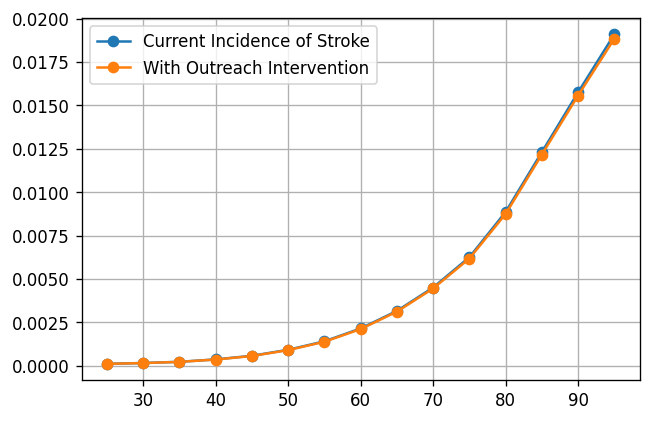

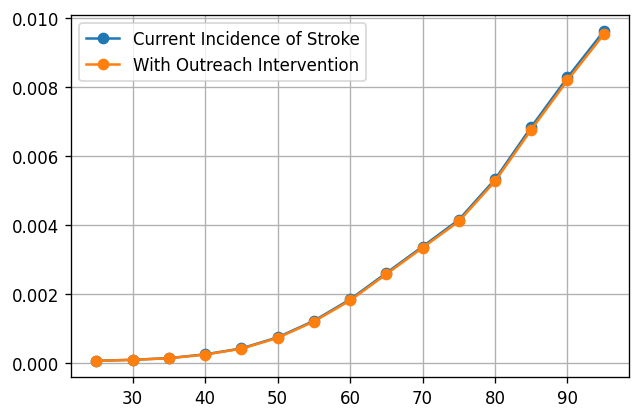

In [30]:
for sex in stroke.sex.unique():
    plt.figure(dpi=120)
    subdata = stroke.loc[stroke['sex']==sex]
    plt.plot(subdata.age_start, subdata.stroke_inc, marker='o', label='Current Incidence of Stroke')
    plt.plot(subdata.age_start, subdata.new_inc, marker='o', label='With Outreach Intervention')
    plt.legend()
    plt.grid()

In [31]:
stroke['decrease_stroke'] = (stroke['stroke_inc'] - stroke['new_inc']) * 213000000
stroke['decrease_stroke'].sum()

313357.7047760029